In [39]:
import os
import math
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [6]:
df_message_AAPL = pd.read_csv("Data/LOBSTER_SampleFile_AAPL_2012-06-21_50/AAPL_2012-06-21_34200000_37800000_message_50.csv")
df_message_AAPL.head()

,34200.004241176,1,16113575,18,5853300,1.1
0,34200.004261,1,16113584,18,5853200,1
1,34200.004447,1,16113594,18,5853100,1
2,34200.025552,1,16120456,18,5859100,-1
3,34200.025580,1,16120480,18,5859200,-1
4,34200.025613,1,16120503,18,5859300,-1


In [7]:
df_AAPL_OB  = pd.read_csv("Data/LOBSTER_SampleFile_AAPL_2012-06-21_50/AAPL_2012-06-21_34200000_37800000_orderbook_50.csv")
df_AAPL_OB.head()

,5859400,200,5853300,18,5859800,200.1,5853000,150,5861000,200.2,...,4689600,200.4,9999999999.8,0.8,4689500,1900,9999999999.9,0.9,4689400,400.3
0,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,4736500,100,9999999999,0,4689600,200,9999999999,0,4689500,1900
1,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
2,5859100,18,5853300,18,5859400,200,5853200,18,5859800,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
3,5859100,18,5853300,18,5859200,18,5853200,18,5859400,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
4,5859100,18,5853300,18,5859200,18,5853200,18,5859300,18,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200


In [8]:
# Renommer les colonnes de df_messages selon la spécification
rename_mapping = {
    df_message_AAPL.columns[0]: "Time",        # Seconds after midnight (float, ms à ns)
    df_message_AAPL.columns[1]: "Type",        # Type d'événement (1,2,3,4,5,7)
    df_message_AAPL.columns[2]: "OrderID",     # Identifiant unique de l'ordre
    df_message_AAPL.columns[3]: "Size",        # Nombre d'actions
    df_message_AAPL.columns[4]: "Price",       # Prix * 10 000
    df_message_AAPL.columns[5]: "Direction"    # -1: Sell, 1: Buy
}

df_message_AAPL = df_message_AAPL.rename(columns=rename_mapping)

# Vérification
print(df_message_AAPL.head())
print("\nColonnes renommées :", df_message_AAPL.columns.tolist())

           Time  Type   OrderID  Size    Price  Direction
0  34200.004261     1  16113584    18  5853200          1
1  34200.004447     1  16113594    18  5853100          1
2  34200.025552     1  16120456    18  5859100         -1
3  34200.025580     1  16120480    18  5859200         -1
4  34200.025613     1  16120503    18  5859300         -1

Colonnes renommées : ['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']


In [9]:
# Nombre de niveaux du carnet d'ordres
num_levels = 50

# Construction de la liste des nouveaux noms de colonnes
new_columns = []
for level in range(1, num_levels + 1):
    new_columns += [
        f"AskPrice_{level}",  # Prix Ask du niveau i
        f"AskSize_{level}",   # Volume Ask du niveau i
        f"BidPrice_{level}",  # Prix Bid du niveau i
        f"BidSize_{level}",   # Volume Bid du niveau i
    ]

# Vérification du nombre de colonnes
if len(df_AAPL_OB.columns) != len(new_columns):
    raise ValueError(
        f"Le DataFrame df_OB contient {len(df_AAPL_OB.columns)} colonnes, "
        f"mais {len(new_columns)} étaient attendues pour {num_levels} niveaux."
    )

# Application du renommage
df_AAPL_OB.columns = new_columns

# Vérification
print(df_AAPL_OB.columns[:8])  # affiche les premières colonnes pour vérif
print(f"\nTotal colonnes renommées : {len(df_AAPL_OB.columns)}")


Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2'],
      dtype='object')

Total colonnes renommées : 200


In [22]:
# df_message_AAPL.to_csv("Data/AAPL_message.csv")
# df_AAPL_OB.to_csv('Data/AAPL_OB.csv')

In [33]:
def plot_label_distribution(y):
    """Affiche la distribution des classes de labels."""
    unique, counts = np.unique(y, return_counts=True)
    labels = ["Down (0)", "Flat (1)", "Up (2)"]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=["red", "gray", "green"])
    plt.title("Distribution des labels (mouvements de mid-price)")
    plt.ylabel("Nombre d'occurrences")
    plt.show()

In [34]:
def plot_midprice_with_labels(mid_prices, y, label_horizon=10, sample_len=2000):
    """
    Affiche le mid-price et les zones où le label est up/down/flat.
    - mid_prices : np.array des mid-prices
    - y : np.array des labels
    - label_horizon : horizon en ticks (pour aligner)
    - sample_len : nombre de points à tracer
    """
    plt.figure(figsize=(12, 5))
    x = np.arange(sample_len)
    plt.plot(x, mid_prices[:sample_len], color="black", linewidth=1, label="Mid-price")

    for i in range(sample_len - label_horizon):
        if y[i] == 2:
            plt.axvspan(i, i+1, color="green", alpha=0.3)
        elif y[i] == 0:
            plt.axvspan(i, i+1, color="red", alpha=0.3)
        else:
            plt.axvspan(i, i+1, color="gray", alpha=0.2)

    plt.title(f"Mid-price avec coloration des labels (horizon={label_horizon} ticks)")
    plt.xlabel("Ticks")
    plt.ylabel("Mid-price")
    plt.legend()
    plt.show()

In [35]:
def plot_example_snapshot(X, idx=0):
    """
    Affiche la matrice d'un snapshot (fenêtre temporelle) sous forme d'image.
    Chaque ligne = un tick ; chaque colonne = une feature (Ask/Bid Price/Size).
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(X[idx], aspect="auto", cmap="viridis")
    plt.colorbar(label="Valeur normalisée")
    plt.title(f"Snapshot #{idx} (fenêtre LOB)")
    plt.xlabel("Features (Ask/Bid Price/Size)")
    plt.ylabel("Ticks dans la fenêtre")
    plt.show()

In [ ]:
def preprocess_lobster(message_path: str,
                       orderbook_path: str,
                       window_size: int = 100,
                       levels: int = 50,
                       label_horizon: int = 10,
                       out_dir: str = "Data"):
    """
    Prétraite les fichiers LOBSTER-like en snapshots numpy pour DeepLOB.

    Args:
        message_path (str): chemin vers le fichier message.csv (renommé)
        orderbook_path (str): chemin vers le fichier orderbook.csv (renommé)
        window_size (int): longueur de la fenêtre temporelle (nombre de ticks)
        levels (int): nombre de niveaux du carnet à conserver (Ask/Bid)
        label_horizon (int): horizon en ticks pour calculer le mouvement du mid-price
        out_dir (str): dossier de sortie pour sauvegarder les fichiers .npy
    """
    print(f"[INFO] Chargement des fichiers : {message_path}, {orderbook_path}")
    df_message = pd.read_csv(message_path)
    df_OB = pd.read_csv(orderbook_path)

    # Vérif colonnes attendues
    assert "Time" in df_message.columns, "df_message doit contenir la colonne 'Time'"
    assert "AskPrice_1" in df_OB.columns, "df_OB doit contenir 'AskPrice_1'"

    # Nettoyage : valeurs sentinelles
    df_OB = df_OB.replace(-9999999999, np.nan).ffill()

    # Conversion des prix (LOBSTER = prix * 10000)
    for col in df_OB.columns:
        if "Price" in col:
            df_OB[col] = df_OB[col] / 10000.0

    # ========================
    # Calcul du mid-price
    # ========================
    mid_prices = (df_OB["AskPrice_1"].values + df_OB["BidPrice_1"].values) / 2

    # Horizon futur (en ticks)
    future_mid = np.roll(mid_prices, -label_horizon)
    price_diff = future_mid - mid_prices

    # Labels : {0 = down, 1 = flat, 2 = up}
    y = np.zeros_like(price_diff, dtype=int)
    y[price_diff > 0] = 2
    y[price_diff < 0] = 0
    y[price_diff == 0] = 1

    # Supprimer les derniers points invalides
    valid_range = len(df_OB) - label_horizon
    y = y[:valid_range]

    # ========================
    # Création des snapshots
    # ========================
    feature_cols = []
    for lvl in range(1, levels + 1):
        feature_cols += [f"AskPrice_{lvl}", f"AskSize_{lvl}", f"BidPrice_{lvl}", f"BidSize_{lvl}"]

    assert all(c in df_OB.columns for c in feature_cols), \
        "Les colonnes du carnet d’ordres ne correspondent pas aux niveaux attendus."

    X = []
    for i in tqdm(range(valid_range - window_size), desc="Création des fenêtres"):
        X.append(df_OB.loc[i:i + window_size - 1, feature_cols].values)
    X = np.stack(X)
    y = y[window_size:]

    print(f"[INFO] Snapshots créés : X={X.shape}, y={y.shape}")

    # --- Visualisation exploratoire ---
    plot_label_distribution(y)
    plot_midprice_with_labels(mid_prices, y, label_horizon=label_horizon, sample_len=2000)
    plot_example_snapshot(X, idx=0)

    os.makedirs(out_dir, exist_ok=True)
    np.save(os.path.join(out_dir, "snapshots.npy"), X)
    np.save(os.path.join(out_dir, "labels.npy"), y)
    print(f"[INFO] Sauvegarde : {out_dir}/snapshots.npy et labels.npy")

In [24]:
# =========================================================
# 2. Dataset PyTorch
# =========================================================

class LOBDataset(Dataset):
    """Dataset PyTorch compatible DeepLOB"""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert len(X) == len(y)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (window, features)
        y = self.y[idx]
        x = np.transpose(x, (1, 0)).copy()  # (features, window)
        return torch.from_numpy(x), torch.tensor(y)

In [25]:
# =========================================================
# 3. Modèle DeepLOB-like
# =========================================================

class InceptionBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        assert out_ch % 4 == 0
        per = out_ch // 4
        self.b1 = nn.Conv1d(in_ch, per, kernel_size=1)
        self.b2 = nn.Conv1d(in_ch, per, kernel_size=3, padding=1)
        self.b3 = nn.Conv1d(in_ch, per, kernel_size=5, padding=2)
        self.b4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_ch, per, kernel_size=1)
        )
        self.bn = nn.BatchNorm1d(out_ch)

    def forward(self, x):
        b1 = F.relu(self.b1(x))
        b2 = F.relu(self.b2(x))
        b3 = F.relu(self.b3(x))
        b4 = F.relu(self.b4(x))
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.bn(out)

In [26]:
class DeepLOB(nn.Module):
    def __init__(self, in_channels, n_classes=3, lstm_hidden=128):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.inc1 = InceptionBlock(64, 128)
        self.inc2 = InceptionBlock(128, 128)
        self.conv_down = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden * 2, 64)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.inc1(x)
        x = self.inc2(x)
        x = F.relu(self.bn2(self.conv_down(x)))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = F.relu(self.fc(out))
        return self.out(out)

In [27]:
# =========================================================
# 4. Entraînement / Validation / Test
# =========================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses, preds, trues = [], [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds.extend(logits.argmax(1).cpu().numpy())
        trues.extend(y.cpu().numpy())
    return np.mean(losses), accuracy_score(trues, preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    losses, preds, trues = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
            preds.extend(logits.argmax(1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    return np.mean(losses), accuracy_score(trues, preds), classification_report(trues, preds)


In [28]:
def run_training(path_snapshots, path_labels,
                 out_dir="checkpoints",
                 batch_size=128, epochs=10, lr=1e-3, n_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = np.load(path_snapshots)
    y = np.load(path_labels)

    N = len(X)
    n_val = int(N * 0.15)
    n_test = int(N * 0.15)
    train_idx = np.arange(0, N - n_val - n_test)
    val_idx = np.arange(N - n_val - n_test, N - n_test)
    test_idx = np.arange(N - n_test, N)

    ds_train = LOBDataset(X[train_idx], y[train_idx])
    ds_val = LOBDataset(X[val_idx], y[val_idx])
    ds_test = LOBDataset(X[test_idx], y[test_idx])

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=batch_size)
    loader_test = DataLoader(ds_test, batch_size=batch_size)

    in_ch, seq_len = ds_train[0][0].shape
    model = DeepLOB(in_channels=in_ch, n_classes=n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val = -math.inf
    os.makedirs(out_dir, exist_ok=True)

    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, loader_train, optimizer, criterion, device)
        val_loss, val_acc, _ = evaluate(model, loader_val, criterion, device)
        print(f"Epoch {ep}: train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), os.path.join(out_dir, "best.pth"))

    model.load_state_dict(torch.load(os.path.join(out_dir, "best.pth"), map_location=device))
    test_loss, test_acc, report = evaluate(model, loader_test, criterion, device)
    print("=== TEST ===")
    print(report)

[INFO] Chargement des fichiers : Data/AAPL_message.csv, data/AAPL_OB.csv


Création des fenêtres: 100%|██████████| 91886/91886 [23:38<00:00, 64.76it/s]


[INFO] Snapshots créés : X=(91886, 100, 200), y=(91886,)


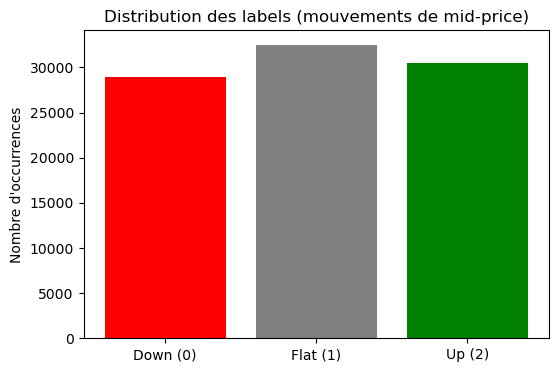

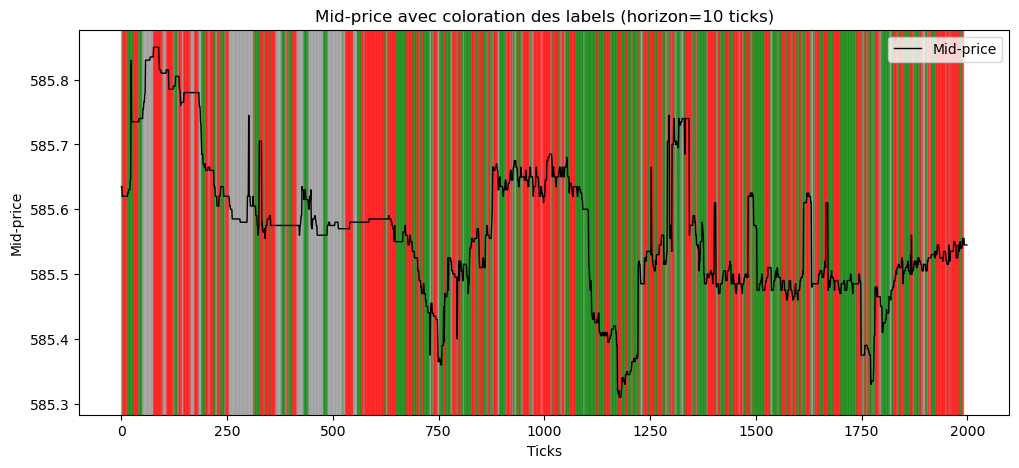

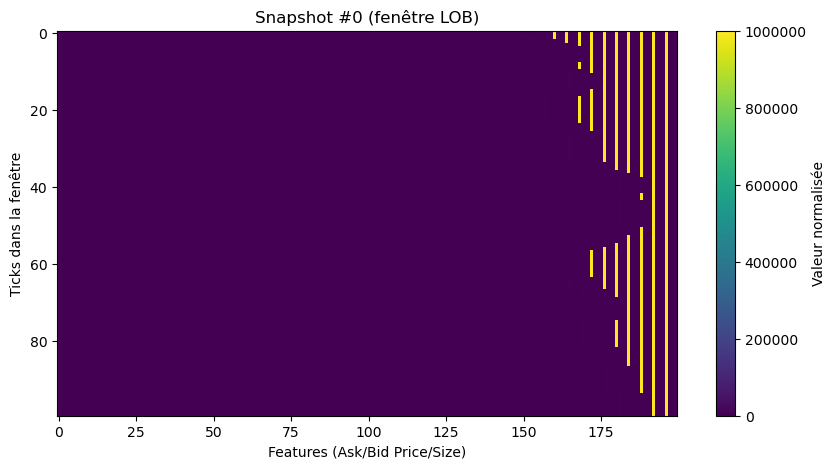

[INFO] Sauvegarde : data/snapshots.npy et labels.npy
Epoch 1: train 1.0443/0.4434 | val 1.1047/0.4459


KeyboardInterrupt: 

In [ ]:
# =========================================================
# 5. Exemple d’utilisation -> should run it on colab not on local
# =========================================================

if __name__ == "__main__":
    # Exemple : prétraitement puis entraînement
    # preprocess_lobster("Data/AAPL_message.csv",
    #                   "data/AAPL_OB.csv",
    #                   window_size=100, levels=50, label_horizon=10)

    PATH_SNAP = "Data/snapshots.npy"
    PATH_LABELS = "Data/labels.npy"
    run_training(PATH_SNAP, PATH_LABELS)